## Phase diagram on composition plane

Phase diagram on composition plane $(\phi_A, \phi_B)$ with given $\eta_{SS'}$, $\rho_S$, $\bar{\rho}_S$. Here, $\omega_{SS'}$ becomes

$$
\omega_{SS'} = \frac{\phi_S}{\bar{v}_S} \left.\frac{\partial v_{S}}{\partial \rho_{S'}}\right|_{\{\phi_S\}},
$$
where $\bar{v}_S = v_S(\phi_A, \phi_B)$ and $v_S$ is determined by
$$
v_S(\rho_A(\mathbf{r}), \rho_B(\mathbf{r})) = v_{S,0} \tilde{v}_{SA}(\rho_A(\mathbf{r}))\tilde{v}_{SB}(\rho_B(\mathbf{r})),
$$
with
$$
\begin{aligned}
\tilde{v}_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\bar{\rho}_A}{\rho_0}
	\right),\\
\tilde{v}_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\bar{\rho}_B}{\rho_0}
	\right).
\end{aligned}
$$
Then
$$\omega_{SS'}=\frac{\phi_S}{\tilde{v}_{SS'}(\phi_{S'})} \tilde{v}_{SS'}'(\phi_{S'}),$$
where
$$
\begin{aligned}
\tilde{v}_{SA}'(\rho_A)&=\partial_{\rho_A} \tilde{v}_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'(\rho_B)&=\partial_{\rho_B} \tilde{v}_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SB}-1}{\kappa}\right)^2
\right].
\end{aligned}
$$

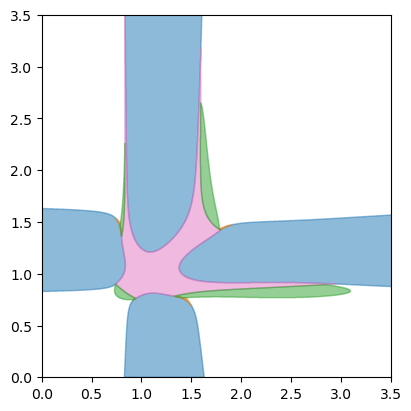

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as mpatches
import os

from cal_omega_barV import get_bar_v_omega
from general_PD import find_long_instabi, find_short_instabi, find_contours


def get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA=1, bar_vB=1, kappa=0.7,
                            extent=[0, 4, 0, 4], qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=3./20, simple_gamma=False):
    if simple_gamma:
        folder = "data/PD_pA_pB_SG/"
    elif ll == 0.:
        folder = "data/PD_pA_pB_woS/"
    else:
        folder = "data/PD_pA_pB/"
    fout = "%se%g_%g_%g_%g_D%g_%g_r%g_%g_qm%g_r%g.npz" % (
        folder, etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, qmax, resolution
    )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        pA = np.linspace(extent[0], extent[1], ncols)
        pB = np.linspace(extent[2], extent[3], nrows)
        pA_2D, pB_2D = np.meshgrid(pA, pB)
        vA_0, vB_0, wAA, wAB, wBA, wBB = get_bar_v_omega(
            etaAA, etaAB, etaBA, etaBB, pA_2D, pB_2D, bar_rho_A, bar_rho_B, bar_vA, bar_vB, kappa)
        w1 = 1 + wAA
        w2 = 1 + wBB
        wc = wAB * wBA
        sigma_D = Dr_A / Dr_B
        sigma_v = vA_0 / vB_0
        Pe = vB_0 / Dr_B

        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=qmin, ll=ll, simple_gamma=simple_gamma)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
            for col in range(ncols):
                if mask_LS[row, col]:
                    q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                        sigma_D, sigma_v[row, col], Pe[row, col], w1[row, col], w2[row, col], wc[row, col], qmin=qmin, qmax=qmax, Nq=Nq, ll=ll, simple_gamma=simple_gamma)
        state = np.zeros((nrows, ncols), dtype=np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_composition(state, extent, xlim=None, ylim=None, ax=None, fill=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:blue", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:blue", lw=1)
    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:pink", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:pink", lw=1)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:orange", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:orange", lw=1)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:green", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:green", lw=1)
    # # ax.plot(1, 1, "o", ms=2, c="k")

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()


def plot_state(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    im = ax.imshow(state, origin="lower", extent=extent)
    fig.colorbar(im, ax=ax)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()

def plot_PD_composition_Turing(state, extent, xlim=None, ylim=None, ax=None, fill=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    x_center = None
    y_center = None
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        
        if fill:
            if x[0] == x[-1]:
                ax.fill(x, y, c="tab:blue", alpha=0.5)
            else:
                if x_center is None:
                    x_center = x
                    y_center = y
                else:
                    if y[0] != y_center[0]:
                        x_center = np.hstack((x_center, x))
                        y_center = np.hstack((y_center, y))
                    else:
                        x_center = np.hstack((x_center, x[::-1]))
                        y_center = np.hstack((y_center, y[::-1]))
        else:
            ax.plot(x, y, c="tab:blue", lw=1)
    if fill:
        ax.fill(x_center, y_center, c="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:pink", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:pink", lw=1)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:orange", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:orange", lw=1)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:green", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:green", lw=1)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()

# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000, ll=0.)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2, Nq=400, resolution=4000)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

Dr = 0.1
etaAA = -2
etaBB = -2
etaAB = 0.5
etaBA = -0.5
# plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])
# plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])


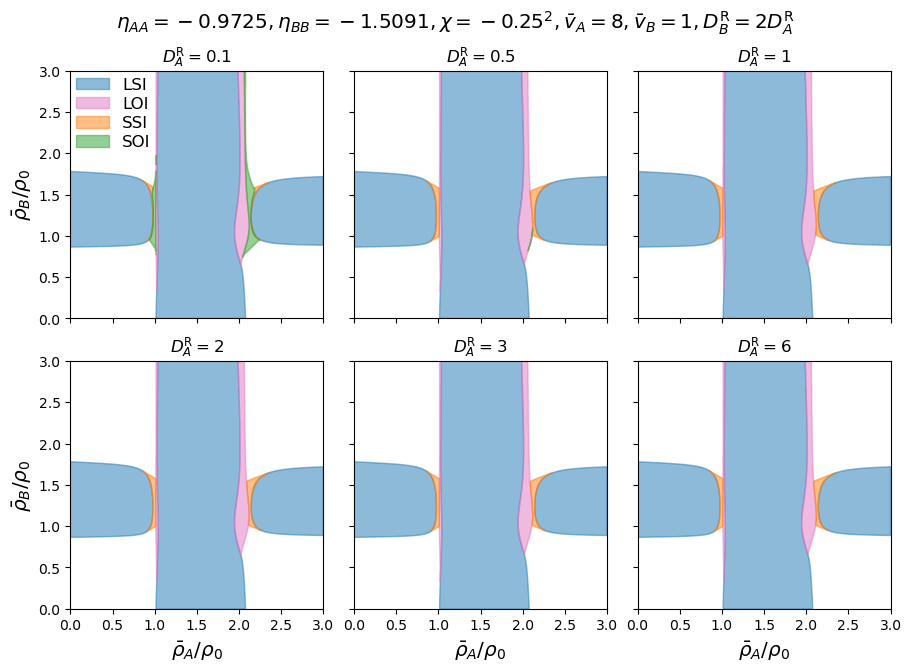

In [2]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6.6), constrained_layout=True, sharex=True, sharey=True)
Dr_A_arr = np.array([0.1, 0.5, 1, 2, 3, 6])

for i, ax in enumerate(axes.flat):
    Dr_A = Dr_A_arr[i]
    Dr_B = Dr_A * 2
    bar_vA = 8
    bar_vB = 1
    etaAA = -0.9725
    etaBB = -1.5091
    etaAB = -0.25
    etaBA = -0.25** 2 / etaAB
    # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
    extent = [0, 3, 0, 3]
    extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, 1, 1, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=2000, extent=extent)
    plot_PD_composition_Turing(state, extent, xlim=[0, 3], ylim=[0, 3], ax=ax, fill=True)

    if i // 3 == 1:
        ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
    if i % 3 == 0:
        ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
    ax.set_title(r"$D_A^{\rm R}=%g$" % Dr_A)
    # ax.plot(1, 1, "x", c='k', ms=1)

patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
        mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
        mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5),
        mpatches.Patch(color='tab:green', label='SOI', alpha=0.5)
        ]
legend = axes[0, 0].legend(handles=patches, loc=(0.02, 0.68), fontsize="large", labelspacing=0.25, frameon=False, borderpad=0.01)
fig.suptitle(r"$\eta_{AA}=-0.9725,\eta_{BB}=-1.5091,\chi=-0.25^2, \bar{v}_A=8,\bar{v}_B=1, D_B^{\rm R}=2D_A^{\rm R}$", fontsize="x-large")
plt.show()
# plt.savefig("fig/PD_Turing_varied_DrA.pdf")
plt.close()

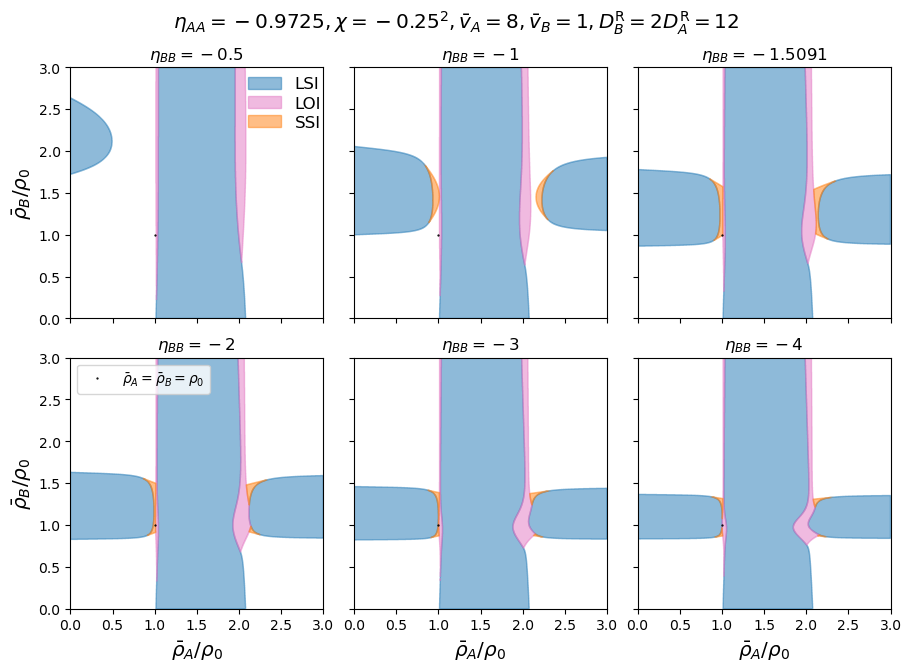

In [3]:

# for etaBB in [-0.5, -1, -1.5091, -2, -2.5, -3, -3.5, -4]:
#     Dr_A = 6
#     Dr_B = Dr_A * 2
#     bar_vA = 8
#     bar_vB = 1
#     etaAA = -0.9725
#     # etaBB = -2.7
#     etaAB = -0.25
#     etaBA = -0.25** 2 / etaAB
#     # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
#     extent = [0, 3, 0, 3]
#     extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, 1, 1, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=2000, extent=extent)
# #     plt.imshow(state, origin="lower", extent=[0, 3, 0, 3])
# #     plt.colorbar()
# #     plt.xlim(0, 3)
# #     plt.ylim(0, 3)
# #     plt.show()
# #     plt.close()
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
#     plot_PD_composition_Turing(state, extent, xlim=[0, 3], ylim=[0, 3], ax=ax, fill=True)

#     patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
#             mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
#             mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5),
#             ]
#     legend = ax.legend(handles=patches, loc="upper right", fontsize="xx-large", labelspacing=0.25)
#     ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
#     ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
#     ax.plot(1, 1, "x", c='k', ms=1)
#     plt.show()
#     plt.close()

fig, axes = plt.subplots(2, 3, figsize=(9, 6.6), constrained_layout=True, sharex=True, sharey=True)
eta_BB_arr = np.array([-0.5, -1, -1.5091, -2, -3, -4])

for i, ax in enumerate(axes.flat):
    Dr_A = 6
    Dr_B = Dr_A * 2
    bar_vA = 8
    bar_vB = 1
    etaAA = -0.9725
    etaBB = eta_BB_arr[i]
    etaAB = -0.25
    etaBA = -0.25** 2 / etaAB
    # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
    extent = [0, 3, 0, 3]
    extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, 1, 1, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=2000, extent=extent)
    plot_PD_composition_Turing(state, extent, xlim=[0, 3], ylim=[0, 3], ax=ax, fill=True)

    if i // 3 == 1:
        ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
    if i % 3 == 0:
        ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
    ax.set_title(r"$\eta_{BB}=%g$" % etaBB)
    ax.plot(1, 1, "o", c='k', ms=0.6, label=r"$\bar{\rho}_A=\bar{\rho}_B=\rho_0$")
    if i == 3:
        ax.legend(loc="upper left")
    

patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
        mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
        mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5)
        # mpatches.Patch(color='tab:green', label='LOI', alpha=0.5)
        ]
legend = axes[0, 0].legend(handles=patches, loc=(0.7, 0.75), fontsize="large", labelspacing=0.25, frameon=False, borderpad=0.01)
fig.suptitle(r"$\eta_{AA}=-0.9725,\chi=-0.25^2, \bar{v}_A=8,\bar{v}_B=1, D_B^{\rm R}=2D_A^{\rm R}=12$", fontsize="x-large")
plt.show()
# plt.savefig("fig/PD_Turing_varied_etaBB.pdf")
plt.close()

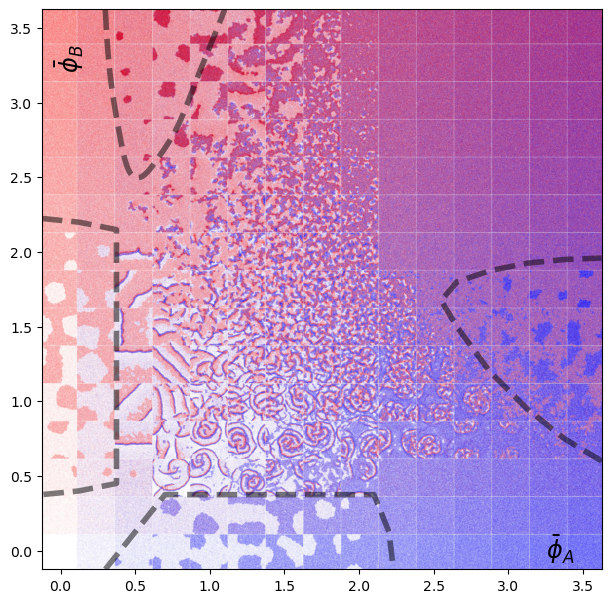

In [4]:
def load_composition_plane(ax=None, label_font_size="xx-large"):
    from scipy.interpolate import CubicSpline
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    image = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.50_reduced.jpeg")
    extent = [-0.125, 3.625, -0.125, 3.625]
    ax.imshow(image, extent=extent)
    ax.text(0.9, 0.02, r"$\bar{\phi}_A$", fontsize=label_font_size, transform=ax.transAxes)
    ax.text(0.02, 0.9, r"$\bar{\phi}_B$", fontsize=label_font_size, rotation=90, transform=ax.transAxes)

    x_u =np.array([0.3, 0.315, 0.34, 0.38, 0.43, 0.5, 0.65, 0.8, 0.9, 1, 1.1])
    y_u =np.array([3.625, 3.375, 3.125, 2.875, 2.625, 2.5, 2.625, 2.875, 3.125, 3.375, 3.625])
    # ax.plot(x_u, y_u, "o")
    
    cs = CubicSpline(x_u, y_u)
    xs = np.linspace(x_u[0], x_u[-1], 100)
    ys = cs(xs)

    ax.plot(xs, ys, "--", lw=4, c="k", alpha=0.5)
    
    x_l = np.array([-0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.125, -0.125])
    y_l = np.array([2.225, 2.2, 2.15, 1.875, 1.655, 1.0, 0.75, 0.45, 0.4, 0.375])

    ax.plot(x_l, y_l, "--", lw=4, c="k", alpha=0.5)
    # cs = CubicSpline(y_l[::-1], x_l[::-1])
    # ys = np.linspace(y_l[-1], y_l[0], 100)
    # xs = cs(ys)

    x_d = np.array([0.3, 0.5, 0.7, 2.1, 2.2, 2.23])
    y_d = np.array([-0.125, 0.125, 0.375, 0.375, 0.125, -0.125])
    ax.plot(x_d, y_d, "--", lw=4, c="k", alpha=0.5)

    x_r = np.array([3.625, 3.375, 3.125, 2.875, 2.655, 2.55, 2.655, 2.875, 3.125, 3.375, 3.625])
    y_r = np.array([0.6, 0.75, 0.95, 1.2, 1.5, 1.675, 1.8, 1.875, 1.925, 1.95, 1.96])
    # ax.plot(x_r, y_r, "o", c="tab:red")
    ax.plot(x_r, y_r, "--", lw=4, c="k", alpha=0.5)

    if flag_show:
        plt.show()
        plt.close()

load_composition_plane()

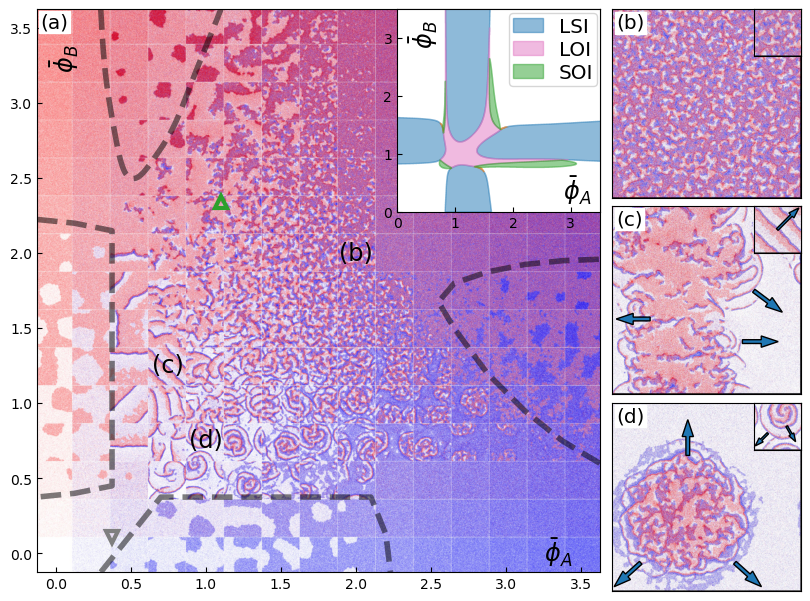

In [5]:
# FIG2: (a) phase diagram on (phiA, phiB) with eta=-2, eta_AB=0.5, L=40.
# (b,c,d) Typical snapshots with L=160
import matplotlib.patches as mpatches

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(constrained_layout=True, figsize=(8, 5.9))
# fig = plt.figure(figsize=(8, 5.9))

subfigs = fig.subfigures(1, 2, wspace=0.0001, hspace=0.0001, width_ratios=[3, 1])

ax1 = subfigs[0].subplots(1, 1, gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))
(ax2, ax3, ax4) = subfigs[1].subplots(3, 1, gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))

### ax1
ax1_in = ax1.inset_axes([0.64, 0.64, 0.36, 0.36])
Dr = 0.1
etaAA = etaBB = -2
etaAB = 0.5
etaBA = -etaAB
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5], ax=ax1_in)
ax1_in.set_yticks([0, 1, 2, 3])
# image = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.50_reduced.jpeg")
# extent = [-0.125, 3.625, -0.125, 3.625]
# ax1.imshow(image, extent=extent)
# ax1.set_xlabel(r"$\phi_A/\rho_0$", fontsize="large")
# ax1.set_ylabel(r"$\phi_B/\rho_0$", fontsize="large")
load_composition_plane(ax1)

# ax1.plot(3.8935/10, 1.2001/10, "v", fillstyle="none", c="tab:grey", ms=9, mew=3)
# ax1.plot(11.0367/10, 21.6776/10, "^", fillstyle="none", c="tab:green", ms=9, mew=3)
ax1.plot(3.7562/10, 1.111/10, "v", fillstyle="none", c="tab:grey", ms=9, mew=3)
ax1.plot(11.0441/10, 23.3980/10, "^", fillstyle="none", c="tab:green", ms=9, mew=3)
patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
           mpatches.Patch(color='tab:green', label='SOI', alpha=0.5),
        ]
ax1_in.legend(handles=patches, loc=(0.55, 0.62), fontsize="x-large", borderpad=0.2, labelspacing=0.2, handlelength=1.5)
ax1_in.text(0.82, 0.06, r"$\bar{\phi}_A$", fontsize="xx-large", transform=ax1_in.transAxes)
ax1_in.text(0.05, 0.84, r"$\bar{\phi}_B$", fontsize="xx-large", rotation=90, transform=ax1_in.transAxes)


### ax4
image = mpimg.imread("fig/L160_p20_15_r20_e-2_J05.jpg")
ax4.imshow(image)
ax4.set_xticks([])
ax4.set_yticks([])
ax_in = ax4.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p20_15_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])
ax4.arrow(0.4, 0.72, 0, 0.1, transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax4.arrow(0.15, 0.15, 0.1 * np.cos(-np.pi * 2.3/3), 0.1 * np.sin(-np.pi * 2.3/3), transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax4.arrow(0.65, 0.15, 0.1 * np.cos(-np.pi * 0.7/3), 0.1 * np.sin(-np.pi * 0.7/3), transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax_in.arrow(0.3, 0.35, 0.2 * np.cos(-np.pi * 0.75), 0.2 * np.sin(-np.pi * 0.75), transform=ax_in.transAxes, width=0.04, color="tab:blue", ec="k")
ax_in.arrow(0.7, 0.5, 0.2 * np.cos(-np.pi * 1/3), 0.2 * np.sin(-np.pi * 1/3), transform=ax_in.transAxes, width=0.04, color="tab:blue", ec="k")



### ax3
image = mpimg.imread("fig/L160_p15_25_r20_e-2_J05.jpg")
ax3.imshow(image)
ax3.set_xticks([])
ax3.set_yticks([])
ax_in = ax3.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p15_25_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])
ax3.arrow(0.75, 0.55, 0.08, -0.06, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax3.arrow(0.69, 0.28, 0.1, 0, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax3.arrow(0.2, 0.4, -0.09, 0, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax_in.arrow(0.5, 0.5, 0.3, 0.3, transform=ax_in.transAxes, width=0.05, color="tab:blue", ec="k")

### ax2
image = mpimg.imread("fig/L160_p40_40_r20_e-2_J05.jpg")
ax2.imshow(image)
ax2.set_xticks([])
ax2.set_yticks([])
ax_in = ax2.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p40_40_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.006, 0.968, "(a)", fontsize="x-large", transform=ax1.transAxes, bbox=bbox)
ax2.text(0.02, 0.9, "(b)", fontsize="x-large", transform=ax2.transAxes, bbox=bbox)
ax3.text(0.02, 0.9, "(c)", fontsize="x-large", transform=ax3.transAxes, bbox=bbox)
ax4.text(0.02, 0.9, "(d)", fontsize="x-large", transform=ax4.transAxes, bbox=bbox)

# ax2_in = ax2.inset_axes([0.42, 0.92, 0.08, 0.08])
# ax4_in0.set_xticks([])
# ax4_in0.set_yticks([])
# ax4_in0.scatter(0.4, 0.5, s=60, c="tab:blue", marker="o", edgecolors="k")
# ax1.scatter(2, 2, s=65, c="tab:green", marker="o", edgecolors="k")
# ax1.scatter(15/20, 25/20, s=70, c="tab:pink", marker="s", edgecolors="k")
# ax1.scatter(20/20, 15/20, s=70, c="tab:pink", marker="p", edgecolors="k")

# bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(2, 2, "(b)", fontsize="xx-large", c="k", ha="center", va="center")
ax1.text(15/20, 25/20, "(c)", fontsize="xx-large", c="k", ha="center", va="center")
ax1.text(20/20, 15/20, "(d)", fontsize="xx-large", c="k", ha="center", va="center")

# plt.savefig("fig/f2.pdf", dpi=200)
plt.show()
plt.close()


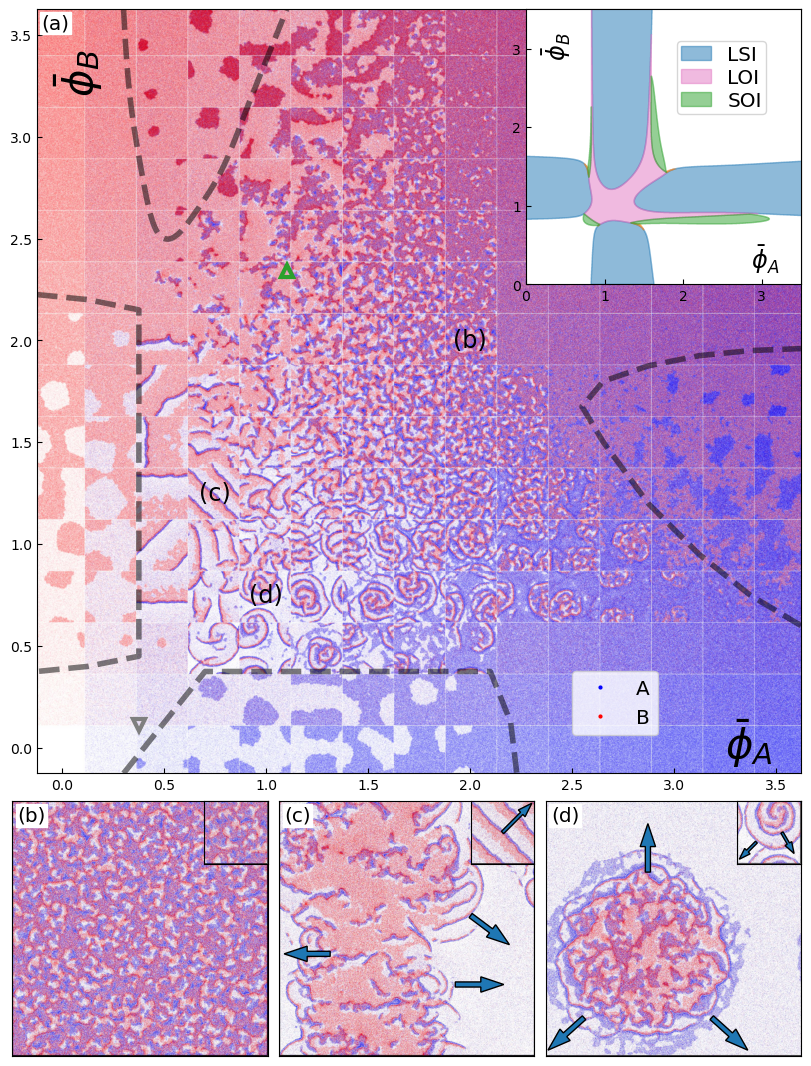

In [6]:
# FIG2: (a) phase diagram on (phiA, phiB) with eta=-2, eta_AB=0.5, L=40.
# (b,c,d) Typical snapshots with L=160
import matplotlib.patches as mpatches

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(constrained_layout=True, figsize=(8, 10.55))
# fig = plt.figure(figsize=(8, 5.9))

subfigs = fig.subfigures(2, 1, wspace=0.0001, hspace=0.0001, height_ratios=[3, 1])

ax1 = subfigs[0].subplots(1, 1, gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))
(ax2, ax3, ax4) = subfigs[1].subplots(1, 3, gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))

### ax1
ax1_in = ax1.inset_axes([0.64, 0.64, 0.36, 0.36])
Dr = 0.1
etaAA = etaBB = -2
etaAB = 0.5
etaBA = -etaAB
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5], ax=ax1_in)
ax1_in.set_yticks([0, 1, 2, 3])
# image = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.50_reduced.jpeg")
# extent = [-0.125, 3.625, -0.125, 3.625]
# ax1.imshow(image, extent=extent)
# ax1.set_xlabel(r"$\phi_A/\rho_0$", fontsize="large")
# ax1.set_ylabel(r"$\phi_B/\rho_0$", fontsize="large")
load_composition_plane(ax1, label_font_size=30)

import matplotlib.lines as mlines
blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=2, label="A", lw=0)
red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=2, label="B", lw=0)
ax1.legend(handles=[blue_circle, red_circle], loc=(0.7, 0.05), fontsize="x-large")

# ax1.plot(3.8935/10, 1.2001/10, "v", fillstyle="none", c="tab:grey", ms=9, mew=3)
# ax1.plot(11.0367/10, 21.6776/10, "^", fillstyle="none", c="tab:green", ms=9, mew=3)
ax1.plot(3.7562/10, 1.111/10, "v", fillstyle="none", c="tab:grey", ms=9, mew=3)
ax1.plot(11.0441/10, 23.3980/10, "^", fillstyle="none", c="tab:green", ms=9, mew=3)
patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
           mpatches.Patch(color='tab:green', label='SOI', alpha=0.5),
        ]
ax1_in.legend(handles=patches, loc=(0.55, 0.62), fontsize="x-large", borderpad=0.2, labelspacing=0.2, handlelength=1.5)
ax1_in.text(0.82, 0.06, r"$\bar{\phi}_A$", fontsize="xx-large", transform=ax1_in.transAxes)
ax1_in.text(0.05, 0.84, r"$\bar{\phi}_B$", fontsize="xx-large", rotation=90, transform=ax1_in.transAxes)


### ax4
image = mpimg.imread("fig/L160_p20_15_r20_e-2_J05.jpg")
ax4.imshow(image)
ax4.set_xticks([])
ax4.set_yticks([])
ax_in = ax4.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p20_15_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])
ax4.arrow(0.4, 0.72, 0, 0.1, transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax4.arrow(0.15, 0.15, 0.1 * np.cos(-np.pi * 2.3/3), 0.1 * np.sin(-np.pi * 2.3/3), transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax4.arrow(0.65, 0.15, 0.1 * np.cos(-np.pi * 0.7/3), 0.1 * np.sin(-np.pi * 0.7/3), transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax_in.arrow(0.3, 0.35, 0.2 * np.cos(-np.pi * 0.75), 0.2 * np.sin(-np.pi * 0.75), transform=ax_in.transAxes, width=0.04, color="tab:blue", ec="k")
ax_in.arrow(0.7, 0.5, 0.2 * np.cos(-np.pi * 1/3), 0.2 * np.sin(-np.pi * 1/3), transform=ax_in.transAxes, width=0.04, color="tab:blue", ec="k")



### ax3
image = mpimg.imread("fig/L160_p15_25_r20_e-2_J05.jpg")
ax3.imshow(image)
ax3.set_xticks([])
ax3.set_yticks([])
ax_in = ax3.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p15_25_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])
ax3.arrow(0.75, 0.55, 0.08, -0.06, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax3.arrow(0.69, 0.28, 0.1, 0, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax3.arrow(0.2, 0.4, -0.09, 0, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax_in.arrow(0.5, 0.5, 0.3, 0.3, transform=ax_in.transAxes, width=0.05, color="tab:blue", ec="k")

### ax2
image = mpimg.imread("fig/L160_p40_40_r20_e-2_J05.jpg")
ax2.imshow(image)
ax2.set_xticks([])
ax2.set_yticks([])
ax_in = ax2.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p40_40_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.006, 0.975, "(a)", fontsize="x-large", transform=ax1.transAxes, bbox=bbox)
ax2.text(0.02, 0.92, "(b)", fontsize="x-large", transform=ax2.transAxes, bbox=bbox)
ax3.text(0.02, 0.92, "(c)", fontsize="x-large", transform=ax3.transAxes, bbox=bbox)
ax4.text(0.02, 0.92, "(d)", fontsize="x-large", transform=ax4.transAxes, bbox=bbox)

# ax2_in = ax2.inset_axes([0.42, 0.92, 0.08, 0.08])
# ax4_in0.set_xticks([])
# ax4_in0.set_yticks([])
# ax4_in0.scatter(0.4, 0.5, s=60, c="tab:blue", marker="o", edgecolors="k")
# ax1.scatter(2, 2, s=65, c="tab:green", marker="o", edgecolors="k")
# ax1.scatter(15/20, 25/20, s=70, c="tab:pink", marker="s", edgecolors="k")
# ax1.scatter(20/20, 15/20, s=70, c="tab:pink", marker="p", edgecolors="k")

# bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(2, 2, "(b)", fontsize="xx-large", c="k", ha="center", va="center")
ax1.text(15/20, 25/20, "(c)", fontsize="xx-large", c="k", ha="center", va="center")
ax1.text(20/20, 15/20, "(d)", fontsize="xx-large", c="k", ha="center", va="center")

# plt.savefig("fig/f2.pdf", dpi=200)
plt.show()
plt.close()


In [7]:
root_rudabeh = "/run/user/1148/gvfs/sftp:host=rudabeh002,user=yduan/scratch03.local/yduan"
root_tahmineh = "/run/user/1148/gvfs/sftp:host=tahmineh002,user=yduan/scratch03.local/yduan"

def get_Lx(fname):
    basename = os.path.basename(fname)
    Lx = float(basename.lstrip("L").split("_")[0])
    return Lx

def get_center(x, y, Lx, inversed=False):
    theta = x / Lx * np.pi * 2
    px = np.mean(np.cos(theta) * y)
    py = np.mean(np.sin(theta) * y)
    theta_m = np.arctan2(py, px)
    if inversed:
        theta_m += np.pi
    if theta_m < 0:
        theta_m += np.pi * 2
    elif theta_m >= np.pi * 2:
        theta_m -= np.pi * 2
    xm = theta_m / (np.pi * 2) * Lx
    return xm

def shift_profile(y, xc, Lx):
    shift = int(Lx / 2 - np.around(xc))
    y_new = np.roll(y, shift)
    return y_new


def get_time_ave_density_profile(fin, beg_frame, end_frame=None, dt=0.01, inversed_A=False, inversed_B=True, shifting_mode="separated"):

    Lx = get_Lx(fin)
    with np.load(fin, "r") as data:
        t, x, y = data["t"] * dt, data["x"], data["y"]
        fields = data["fields"]
    if end_frame is None:
        end_frame = t.size
    n_frames = end_frame - beg_frame
    rho_x_A = np.zeros((n_frames, x.size))
    rho_x_B = np.zeros_like(rho_x_A)
    for i, i_frame in enumerate(np.arange(beg_frame, end_frame)):
        rho_A = np.mean(fields[i_frame][0], axis=0)
        rho_B = np.mean(fields[i_frame][1], axis=0)
        xm_A = get_center(x, rho_A, Lx, inversed=inversed_A)
        xm_B = get_center(x, rho_B, Lx, inversed=inversed_B)
        if shifting_mode == "A":
            xm_B = xm_A
        elif shifting_mode == "B":
            xm_A = xm_B
        rho_x_A[i] = shift_profile(rho_A, xm_A, Lx)
        rho_x_B[i] = shift_profile(rho_B, xm_B, Lx)
    rA = np.mean(rho_x_A, axis=0)
    rB = np.mean(rho_x_B, axis=0)
    return x, rA, rB


def get_time_ave_profile(fin, beg_frame, end_frame=None, dt=0.01, inversed_A=False, inversed_B=True, shifting_mode="separated"):
    Lx = get_Lx(fin)
    with np.load(fin, "r") as data:
        t, x, y = data["t"] * dt, data["x"], data["y"]
        fields = data["fields"]
    if end_frame is None:
        end_frame = t.size
    n_frames = end_frame - beg_frame
    rho_x_A = np.zeros((n_frames, x.size))
    rho_x_B = np.zeros_like(rho_x_A)
    m_x_A = np.zeros_like(rho_x_A)
    m_x_B = np.zeros_like(rho_x_A)
    fields_x = np.zeros((n_frames, 12, x.size))

    # plt.plot(x, np.mean(fields[0, 1], axis=0))
    # plt.show()
    # plt.close()
    for i, frame in enumerate(fields[beg_frame:end_frame]):
        fx = np.zeros((12, x.size))
        ### averaged over the y direction
        fx[:10] = np.mean(frame[:10], axis=1)
        fx[10] = np.mean(frame[0]*frame[6], axis=0)
        fx[11] = np.mean(frame[1]*frame[7], axis=0)


        xm_A = get_center(x, fx[0], Lx, inversed=inversed_A)
        xm_B = get_center(x, fx[1], Lx, inversed=inversed_B)
        if shifting_mode == "A":
            xm_B = xm_A
        elif shifting_mode == "B":
            xm_A = xm_B
        for j in range(fx.shape[0]//2):
            jA = j*2
            jB = jA + 1
            fields_x[i][jA] = shift_profile(fx[jA], xm_A, Lx)
            fields_x[i][jB] = shift_profile(fx[jB], xm_B, Lx)

    fields_x = np.mean(fields_x, axis=0)
    return x, fields_x


def lever_rule():
    prefix = f"{root_tahmineh}/QS_MPI_noself/L480_160_r10_10_10/coarse_grain_dx1"
    fins = [f"{prefix}/L480_160_Dr0.100_k0.70_p7.5_10_r10_10_10_e-2.000_J0.500_-0.500_21010.npz",
            f"{prefix}/L480_160_Dr0.100_k0.70_p8.625_13.36_r10_10_10_e-2.000_J0.500_-0.500_27510.npz",
            f"{prefix}/L480_160_Dr0.100_k0.70_p9.73_16.77_r10_10_10_e-2.000_J0.500_-0.500_28613.npz"
    ]

    fig = plt.figure(figsize=(10, 4.2), constrained_layout=True)
    subfigs = fig.subfigures(1, 2, width_ratios=[4, 6])
    ax1 = subfigs[0].subplots(1, 1)
    ax1.plot(7.5, 10, "o")
    ax1.plot(8.625, 13.36, "o")
    ax1.plot(9.73, 16.77, "o")
    ax1.plot([3.8935, 10.5367], [1.2001, 21.6776], linestyle="dotted", c="tab:grey")
    ax1.plot(3.8935, 1.2001, "v", fillstyle="none", c="tab:grey", label="liquid binodal")
    ax1.plot(10.5367, 21.6776, "^", fillstyle="none", c="tab:brown", label="gas binodal")
    ax1.set_xlabel(r"$\phi_A$", fontsize="large")
    ax1.set_ylabel(r"$\phi_B$", fontsize="large")
    ax1.legend()

    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=True)
    begs = [100, 100, 70]
    phiA = [7.5, 8.625, 9.73]
    phiB = [10, 13.36, 16.77]
    for i, fin in enumerate(fins):
        x, rA, rB = get_time_ave_density_profile(fin, begs[i], inversed_A=False, inversed_B=False)
        ax2.plot(x, rA)
        ax3.plot(x, rB)

        fout = "data/level_rule/p%.3f_%.3f.npz" % (phiA[i], phiB[i])
        np.savez_compressed(fout, x=x, rhoA=rA, rhoB=rB)
    
    ax2.axhline(3.8935, linestyle="dotted", c="tab:grey")
    ax2.axhline(10.5367, linestyle="dashed", c="tab:brown")
    ax3.axhline(1.2001, linestyle="dotted", c="tab:grey")
    ax3.axhline(21.6776, linestyle="dashed", c="tab:brown")
    ax2.set_ylabel(r"$\langle \rho_A\rangle_{y,t}$", fontsize="large")
    ax3.set_ylabel(r"$\langle \rho_B\rangle_{y,t}$", fontsize="large")
    ax3.set_xlabel(r"$x$", fontsize="large")
    ax3.set_xlim(0, 480)

    ax1.set_title("(a)")
    ax2.set_title("(b)")
    ax3.set_title("(c)")

    title = r"$L_x=480,L_y=160,D_r=0.1,\eta=-2,\eta_{AB}=-\eta_{BA}=0.5,\rho_0=\bar{\rho}_{A,B}=10$"
    fig.suptitle(title)

    plt.show()
    plt.close()


# level_rule()


def profiles_two_Lx():
    prefix1 = f"{root_tahmineh}/QS_MPI_noself/L480_160_r10_10_10_h0.333/coarse_grain_dx1"
    fins1 = [f"{prefix1}/L480_160_Dr0.100_k0.70_p7.71_10.5725_r10_10_10_e-2.000_J0.500_-0.500_h0.333_2100.npz",
            f"{prefix1}/L480_160_Dr0.100_k0.70_p8.625_13.36_r10_10_10_e-2.000_J0.500_-0.500_h0.333_2100.npz",
            f"{prefix1}/L480_160_Dr0.100_k0.70_p9.53875_16.1475_r10_10_10_e-2.000_J0.500_-0.500_h0.333_2100.npz"
    ]
    prefix2 = f"{root_tahmineh}/QS_MPI_noself/L960_160_r10_10_10_h0.333/coarse_grain_dx1"
    fins2 = [f"{prefix2}/L960_160_Dr0.100_k0.70_p7.6525_10.5675_r10_10_10_e-2.000_J0.500_-0.500_h0.333_2100.npz",
             f"{prefix2}/L960_160_Dr0.100_k0.70_p8.625_13.36_r10_10_10_e-2.000_J0.500_-0.500_h0.333_2100.npz",
             f"{prefix2}/L960_160_Dr0.100_k0.70_p9.597_16.152_r10_10_10_e-2.000_J0.500_-0.500_h0.333_2100.npz"
    ]

    # fig, axes = plt.subplots(4, 1, figsize=(10, 8), constrained_layout=True)
    
    # with np.load(fins2[1], "r") as data:
    #     t, x, y = data["t"] / 3, data["x"], data["y"]
    #     fields = data["fields"]
    
    # frame = np.mean(fields[1], axis=1)
    # axes[0].plot(x, frame[2])
    # axes[1].plot(x, frame[3])
    # axes[2].plot(x, frame[8])
    # axes[3].plot(x, frame[9])


    begs1 = [100, 100, 100]
    begs2 = [100, 100, 100]
    phi_A1 = [7.71, 8.625, 9.53875]
    phi_B1 = [10.5725, 13.36, 16.1475]

    phi_A2 = [7.6525, 8.625, 9.597]
    phi_B2 = [10.5675, 13.36, 16.152]
    for i in range(3):
        # x, rA, rB = get_time_ave_density_profile(fins1[i], begs1[i], inversed_A=False, inversed_B=False)
        # axes[0].plot(x, rA)
        # axes[1].plot(x, rB)

        # fout = "data/lever_rule/Lx480_p%g_%g.npz" % (phi_A1[i], phi_B1[i])
        # np.savez_compressed(fout, x=x, rhoA=rA, rhoB=rB)

        x, fields = get_time_ave_profile(fins2[i], begs2[i], inversed_A=False, inversed_B=False)
        # axes[0].plot(x, fields[0])
        # axes[1].plot(x, fields[1])
        fout = "data/lever_rule/Lx960_p%g_%g.npz" % (phi_A2[i], phi_B2[i])
        np.savez_compressed(fout, x=x, rhoA=fields[0], rhoB=fields[1], mxA=fields[2], mxB=fields[3], vA=fields[6], vB=fields[7], vPxA=fields[8], vPxB=fields[9])

    # plt.show()
    # plt.close()

profiles_two_Lx()



8.624999999481053


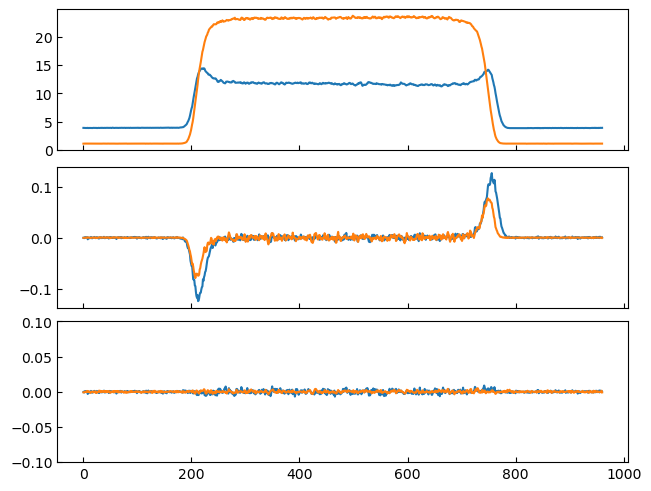

In [8]:
fin = "data/lever_rule/Lx960_p8.625_13.36.npz"

with np.load(fin, "r") as data:
    x, rhoA, rhoB, mxA, mxB, vPxA, vPxB = data["x"], data["rhoA"], data["rhoB"], data["mxA"], data["mxB"], data["vPxA"], data["vPxB"]

fig, axes = plt.subplots(3, 1, constrained_layout=True, sharex=True)

axes[0].plot(x, rhoA)
axes[0].plot(x, rhoB)

axes[1].plot(x, mxA/np.mean(rhoA))
axes[1].plot(x, mxB/np.mean(rhoB))

print(np.mean(rhoA))
axes[2].plot(x, vPxA/np.mean(rhoA))
axes[2].plot(x, vPxB/np.mean(rhoB))
axes[2].set_ylim(-0.1, 0.1)


plt.show()
plt.close()


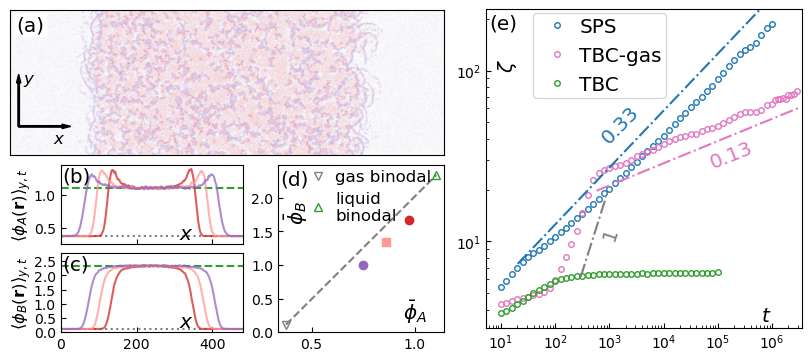

In [9]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

def get_q1(q_radial, Sq):
    """ Get the first moment of s(q, t). """
    I0 = np.sum(Sq)
    I1 = np.sum(q_radial * Sq)
    q1 = I1 / I0
    return q1


def add_line(ax,
             x_beg,
             y_beg,
             x_end,
             slope,
             label=None,
             xl=None,
             yl=None,
             fontsize="x-large",
             scale="log",
             c="#7f7f7f",
             lw=None,
             deg=None):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    if scale == "lin":
        slope_new = slope * (xmax - xmin) / (ymax - ymin)
    else:
        slope_new = slope * (np.log10(xmax / xmin) / np.log10(ymax / ymin))
    x = np.linspace(x_beg, x_end, 100)
    y = slope_new * (x - x_beg) + y_beg
    ax.plot(x, y, "-.", transform=ax.transAxes, color=c, lw=lw)
    if label is not None:
        if deg is None:
            width = ax.bbox.width
            height = ax.bbox.height
            deg = np.arctan(slope_new * height / width) * 180 / np.pi
        dx = x_end - x_beg
        if xl is None:
            xl = x_beg + dx * 0.3
        if yl is None:
            yl = y_beg + dx * 0.6 * slope_new
        ax.text(
            xl,
            yl,
            label,
            transform=ax.transAxes,
            rotation=deg,
            color=c,
            fontsize=fontsize)


fig = plt.figure(constrained_layout=True, figsize=(8, 3.5))
subfigs = fig.subfigures(1, 2, wspace=0.01, hspace=0.01, width_ratios=[5, 4])

subfigs_left = subfigs[0].subfigures(2, 1, wspace=0.001, hspace=0.0005, height_ratios=[3.2, 4])
ax1 = subfigs_left[0].subplots()
subfigs_lower_left = subfigs_left[1].subfigures(1, 2, wspace=0.001, hspace=0.01, width_ratios=[2.4, 2])
ax2, ax3 = subfigs_lower_left[0].subplots(2, 1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0))
# (ax1, ax2, ax3) = subfigs[0].subplots(3, 1)
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig3/L480_160.jpg")
ax1.imshow(im)
ax1.set_xticks([])
ax1.set_yticks([])

# ax2.axhline(3.8935/10, linestyle="dotted", c="tab:grey")
# ax2.axhline(10.5367/10, linestyle="dashed", c="tab:green")
# ax3.axhline(1.2001/10, linestyle="dotted", c="tab:grey")
# ax3.axhline(21.6776/10, linestyle="dashed", c="tab:green")
ax2.axhline(3.7562/10, linestyle="dotted", c="tab:grey")
ax2.axhline(11.0441/10, linestyle="dashed", c="tab:green")
ax3.axhline(1.111/10, linestyle="dotted", c="tab:grey")
ax3.axhline(23.3980/10, linestyle="dashed", c="tab:green")
# files = ["data/lever_rule/p9.730_16.770.npz",
#          "data/lever_rule/p8.625_13.360.npz",
#          "data/lever_rule/p7.500_10.000.npz"
#         ]
files = ["data/lever_rule/Lx480_p7.71_10.5725.npz",
         "data/lever_rule/Lx480_p8.625_13.36.npz",
         "data/lever_rule/Lx480_p9.53875_16.1475.npz"
        ]
c_list = plt.cm.get_cmap('tab20').colors[6:]
for i, fin in enumerate(files):
    with np.load(fin, "rb") as data:
        x = data["x"]
        rhoA = data["rhoA"]
        rhoB = data["rhoB"]
        ax2.plot(x, rhoA/10, c=c_list[i], alpha=0.75)
        ax3.plot(x, rhoB/10, c=c_list[i], alpha=0.75)
ax2.set_xlim(0, 480)
ax3.set_xlim(0, 480)
ax2.set_ylim(ymin=0.25, ymax=1.45)
ax3.set_ylim(ymin=0, ymax=2.8)
ax3.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])

# ax3.set_ylim(0)

ax4 = subfigs_lower_left[1].subplots()
ax4.plot(9.73/10, 16.77/10, "o", c=c_list[0])
ax4.plot(8.625/10, 13.36/10, "s", c=c_list[1])
ax4.plot(7.5/10, 10/10, "o", c=c_list[2])
label1 = "gas binodal"
label2 = "liquid\nbinodal"
# label1 = r"$(\rho_A^{\rm g},\rho_B^{\rm g})$"
# label2 = r"$\{\rho_S^{\rm l}\}$"
# ax4.plot([3.8935/10, 10.5367/10], [1.2001/10, 21.6776/10], linestyle="dashed", c="k", alpha=0.5)
# ax4.plot(3.8935/10, 1.2001/10, "v", fillstyle="none", c="tab:grey", label=label1)
# ax4.plot(10.5367/10, 21.6776/10, "^", fillstyle="none", c="tab:green", label=label2)
ax4.plot([3.7562/10, 11.0441/10], [1.111/10, 23.3980/10], linestyle="dashed", c="k", alpha=0.5)
ax4.plot(3.7562/10, 1.111/10, "v", fillstyle="none", c="tab:grey", label=label1)
ax4.plot(11.0441/10, 23.3980/10, "^", fillstyle="none", c="tab:green", label=label2)
ax4.legend(frameon=False, loc=(0.14, 0.65), handletextpad=0.02, labelspacing=0.4, fontsize="large", borderpad=0)
ax4.set_ylim(ymin=0, ymax=2.49)

ax5 = subfigs[1].subplots()

Sq_folder = "/home/yduan/code/Quorum_sensing/data/Sqt_rho"
fins = [f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p3_6_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5.5_3.85_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L640_640_Dr0.100_k0.70_p20_20_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        # f"{Sq_folder}/L80_80_Dr6.000_6.000_k0.70_p80_80_r80_80_80_e-0.200_-2.200_J-3.125_0.320_h0.100_1000.npz"
        ]
label_list = ["SPS", "TBC-gas", "TBC"]
dt_list = [1/3, 1/3, 1/3, 1/3]
species = ["B", "A", "B", "A"]
c_list = ["tab:blue", "tab:pink", "tab:green", "tab:orange"]
for j, fin in enumerate(fins):
    with np.load(fin, "r") as data:
        t, q, rho_Sqt, rho_var = data["t"], data["q"], data["rho_Sqt"], data["rho_var"]
    if j == 1:
        mask = t <= 3e6
        t = t[mask]
        rho_Sqt = rho_Sqt[:, mask]
    q1_A, q1_B = np.zeros((2, t.size))
    for i in range(t.size):
        q1_A[i] = get_q1(q, rho_Sqt[0][i])
        q1_B[i] = get_q1(q, rho_Sqt[1][i])
    if species[j] == "A":
        R1 = 2 * np.pi/q1_A
    else:
        R1 = 2 * np.pi/q1_B
    
    ax5.plot(t, R1, "o", fillstyle="none", c=c_list[j], ms=4, label=label_list[j])

ax1.arrow(0.02, 0.2, 0.1, 0, transform=ax1.transAxes, width=0.01, color="k", ec="k", head_length=0.02)
ax1.arrow(0.02, 0.2, 0, 0.3, transform=ax1.transAxes, width=0.01/3, color="k", ec="k", head_length=0.02*3)
ax1.text(0.1, 0.08, r"$x$", fontsize="large", transform=ax1.transAxes)
ax1.text(0.03, 0.5, r"$y$", fontsize="large", transform=ax1.transAxes)



ax5.set_xscale("log")
ax5.set_yscale("log")

title_font_size = "x-large"
label_font_size = "x-large"
ax2.set_ylabel(r"$\langle \phi_A(\mathbf{r})\rangle_{y,t}$", fontsize="large", labelpad=0.1)
ax3.set_ylabel(r"$\langle \phi_B(\mathbf{r})\rangle_{y,t}$", fontsize="large", labelpad=0.1)


ax5.legend(fontsize="x-large", loc=(0.15, 0.72), handletextpad=0.1, borderpad=0.2)
ax2.text(0.65, 0.06, r"$x$", fontsize=label_font_size, transform=ax2.transAxes)
ax3.text(0.65, 0.06, r"$x$", fontsize=label_font_size, transform=ax3.transAxes)
ax5.text(0.87, 0.02, r"$t$", fontsize=label_font_size, transform=ax5.transAxes)
ax5.text(0.03, 0.82, r"$\zeta$", fontsize=label_font_size, transform=ax5.transAxes, rotation=90)
ax4.text(0.75, 0.08, r"$\bar{\phi}_A$", fontsize=label_font_size, transform=ax4.transAxes)
ax4.text(0.02, 0.68, r"$\bar{\phi}_B$", fontsize=label_font_size, rotation=90, transform=ax4.transAxes)

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.015, 0.86, "(a)", fontsize="x-large", transform=ax1.transAxes, bbox=bbox)
ax2.text(0.01, 0.79, "(b)", fontsize="x-large", transform=ax2.transAxes)
ax3.text(0.01, 0.79, "(c)", fontsize="x-large", transform=ax3.transAxes)
ax4.text(0.01, 0.88, "(d)", fontsize="x-large", transform=ax4.transAxes)
ax5.text(0.01, 0.94, "(e)", fontsize="x-large", transform=ax5.transAxes)

ax5.set_xlim(xmax=3.5e6)
add_line(ax5, 0.1, 0.2, 0.95, 1/3, label="0.33", yl=0.58, c="tab:blue")
# add_line(ax5, 0.3, 0.4, 0.95, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax5, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax5, 0.3, 0.16, 0.38, 1, label="1", xl=0.36, yl=0.28, c="tab:grey")


plt.show()
# plt.savefig("fig/f3.pdf", dpi=200)
plt.close()

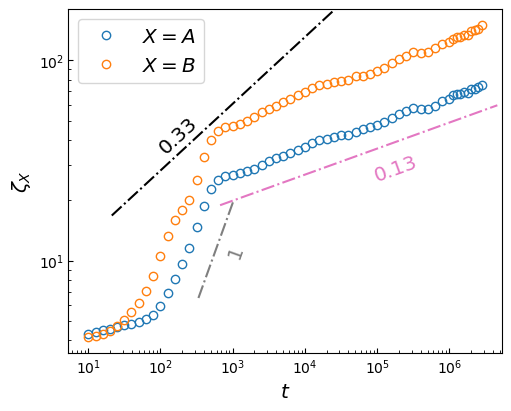

In [10]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)

Sq_folder = "/home/yduan/code/Quorum_sensing/data/Sqt_rho"
fins = [
        # f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p3_6_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5.5_3.85_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        # f"{Sq_folder}/L640_640_Dr0.100_k0.70_p20_20_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        # f"{Sq_folder}/L80_80_Dr6.000_6.000_k0.70_p80_80_r80_80_80_e-0.200_-2.200_J-3.125_0.320_h0.100_1000.npz"
        ]
label_list = ["SPS", "TBC-gas", "TBC"]
dt_list = [1/3, 1/3, 1/3, 1/3]
species = ["B", "A", "B", "A"]
c_list = ["tab:blue", "tab:pink", "tab:green", "tab:orange"]
for j, fin in enumerate(fins):
    with np.load(fin, "r") as data:
        t, q, rho_Sqt, rho_var = data["t"], data["q"], data["rho_Sqt"], data["rho_var"]

    mask = t <= 3e6
    t = t[mask]
    rho_Sqt = rho_Sqt[:, mask]
    q1_A, q1_B = np.zeros((2, t.size))
    for i in range(t.size):
        q1_A[i] = get_q1(q, rho_Sqt[0][i])
        q1_B[i] = get_q1(q, rho_Sqt[1][i])
    
    RA = 2 * np.pi/q1_A
    RB = 2 * np.pi/q1_B
    
    ax.plot(t, RA, "o", fillstyle="none", label=r"$X=A$")
    ax.plot(t, RB, "o", fillstyle="none", label=r"$X=B$")


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$t$", fontsize="x-large")
ax.set_ylabel(r"$\zeta_X$", fontsize="x-large")
ax.legend(fontsize="x-large")

add_line(ax, 0.1, 0.4, 0.95, 1/3, label="0.33", xl=0.2, yl=0.58, c="k")
# add_line(ax5, 0.3, 0.4, 0.95, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax, 0.3, 0.16, 0.38, 1, label="1", xl=0.36, yl=0.28, c="tab:grey")
plt.show()
# plt.savefig("fig/S4.pdf")
plt.close()

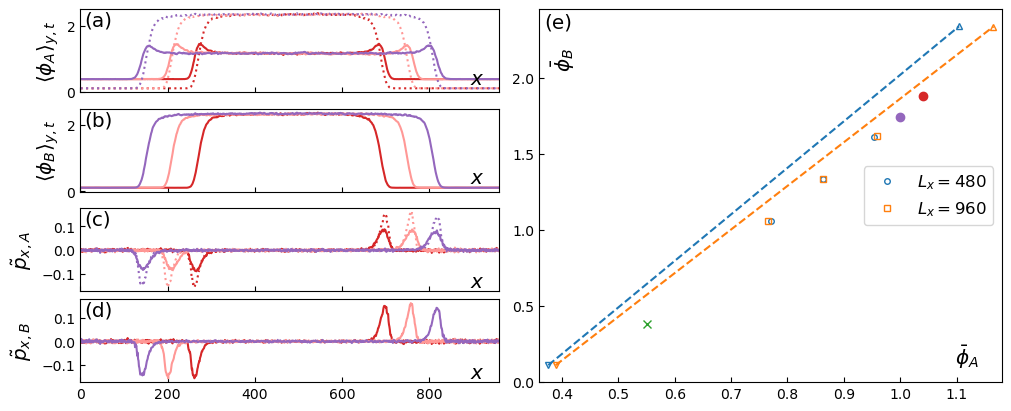

In [11]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.01, hspace=0.01, width_ratios=[5, 5])

ax1, ax2, ax3, ax4 = subfigs[0].subplots(4, 1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0))
# ax3, ax4 = subfigs[1].subplots(2, 1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0))
ax5 = subfigs[1].subplots(1, 1)


files = ["data/lever_rule/Lx960_p7.6525_10.5675.npz",
         "data/lever_rule/Lx960_p8.625_13.36.npz",
         "data/lever_rule/Lx960_p9.597_16.152.npz"
        ]

c_list = plt.cm.get_cmap('tab20').colors[6:]
for i, fin in enumerate(files):
    with np.load(fin, "rb") as data:
        x = data["x"]
        rhoA = data["rhoA"]
        rhoB = data["rhoB"]
        mA = data["mxA"] / data["rhoA"]
        mB = data["mxB"] / data["rhoB"]
        ax1.plot(x, rhoA/10, c=c_list[i])
        ax1.plot(x, rhoB/10, ":", c=c_list[i])

        ax2.plot(x, rhoB/10, c=c_list[i])
        ax3.plot(x, mA, c=c_list[i])
        ax3.plot(x, mB, ":", c=c_list[i])

        ax4.plot(x, mB, c=c_list[i])
ax4.set_xlim(0, 960)

pA0 = [7.71/10, 8.625/10, 9.53875/10]
pB0 = [10.5725/10, 13.36/10, 16.1475/10]

pA1 = [7.6525/10, 8.625/10, 9.597/10]
pB1 = [10.5675/10, 13.36/10, 16.152/10]

# pA0 = [7.71/10, 9.53875/10]
# pB0 = [10.5725/10, 16.1475/10]

# pA1 = [7.6525/10, 9.597/10]
# pB1 = [10.5675/10, 16.152/10]
# for i in range(3):
#     ax5.plot(pA0[i], pB0[i], "s", c=c_list[i], fillstyle="none")
#     ax5.plot(pA1[i], pB1[i], "o", c=c_list[i], fillstyle="none")

# line1, = ax5.plot(8.625/10, 13.36/10, "ks", ms=4, zorder=2.5)
# # line2, = ax5.plot(pA1[1], pB1[1], "s", ms=4)

line1, = ax5.plot(pA0, pB0, "o", fillstyle="none", ms=4, label=r"$L_x=480$")
line2, = ax5.plot(pA1, pB1, "s", fillstyle="none", ms=4, label=r"$L_x=960$")

# x = np.linspace(0.5, 1.1, 100)
# y0 = pB0[0] + (pB0[1] - pB0[0]) / (pA0[1]-pA0[0]) * (x - pA0[0])
# y1 = pB1[0] + (pB1[1] - pB1[0]) / (pA1[1]-pA1[0]) * (x - pA1[0])
# ax5.plot(x, y0, ":", c=line1.get_c())
# ax5.plot(x, y1, ":", c=line2.get_c())

ax5.plot(3.7562/10, 1.111/10, "v", fillstyle="none", c=line1.get_c(), ms=4)
ax5.plot(11.0441/10, 23.3980/10, "^", fillstyle="none", c=line1.get_c(), ms=4)
ax5.plot([3.7562/10, 11.0441/10], [1.111/10, 23.3980/10], linestyle="dashed", c=line1.get_c())

ax5.plot(3.8868/10, 1.11095/10, "v", fillstyle="none", c=line2.get_c(), ms=4)
ax5.plot(11.6549/10, 23.3816/10, "^", fillstyle="none", c=line2.get_c(), ms=4)
ax5.plot([3.8868/10, 11.6549/10], [1.11095/10, 23.3816/10], linestyle="--", c=line2.get_c())

ax5.plot(0.55, 0.385, "x")
ax5.plot(1.04, 1.88, "o")
ax5.plot(1.0, 1.74, "o")


ax5.legend(fontsize="large", loc="center right")

fs = "x-large"
ax1.set_ylabel(r"$\langle\phi_A\rangle_{y, t}$", fontsize=fs)
ax2.set_ylabel(r"$\langle\phi_B\rangle_{y, t}$", fontsize=fs)
ax3.set_ylabel(r"$\tilde{p}_{x, A}$", fontsize=fs)
ax4.set_ylabel(r"$\tilde{p}_{x, B}$", fontsize=fs)

# ax1.set_ylim(ymax=1.6)
ax5.set_xlim(0.36, 1.18)

ax1.text(0.93, 0.1, r"$x$", fontsize="x-large", transform=ax1.transAxes)
ax2.text(0.93, 0.1, r"$x$", fontsize="x-large", transform=ax2.transAxes)
ax3.text(0.93, 0.05, r"$x$", fontsize="x-large", transform=ax3.transAxes)
ax4.text(0.93, 0.05, r"$x$", fontsize="x-large", transform=ax4.transAxes)
ax5.text(0.9, 0.05, r"$\bar{\phi}_A$", fontsize="x-large", transform=ax5.transAxes)
ax5.text(0.02, 0.85, r"$\bar{\phi}_B$", fontsize="x-large", transform=ax5.transAxes, rotation=90)


ax1.text(0.01, 0.8, "(a)", fontsize="x-large", transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize="x-large", transform=ax2.transAxes)
ax3.text(0.01, 0.8, "(c)", fontsize="x-large", transform=ax3.transAxes)
ax4.text(0.01, 0.8, "(d)", fontsize="x-large", transform=ax4.transAxes)
ax5.text(0.01, 0.95, "(e)", fontsize="x-large", transform=ax5.transAxes)
# ax4.set_xticks([0, 160, 320, 480, 640, 800, 960])
# ax2.set_ylim(ymin=0.25, ymax=1.45)
# ax3.set_ylim(ymin=0, ymax=2.8)


# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)
# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)

plt.show()
# plt.savefig("fig/S3.pdf")
plt.close()





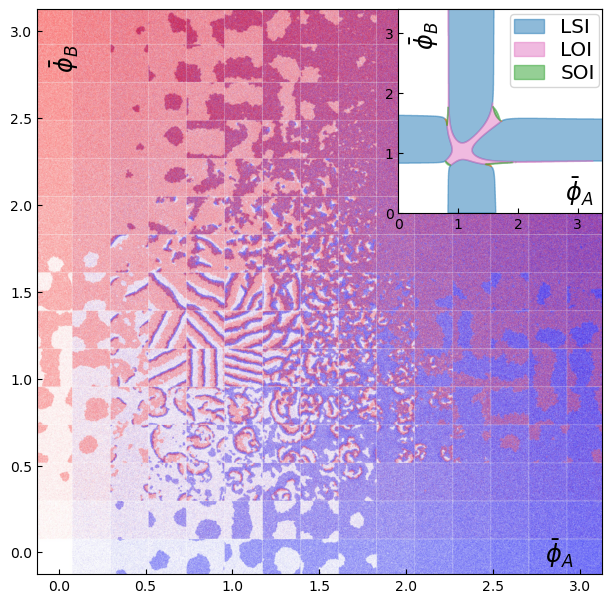

In [12]:
# FIG S1: (a) phase diagram on (phiA, phiB) with eta=-2, eta_AB=0.25, L=40.
# (b,c,d) Typical snapshots with L=160
import matplotlib.patches as mpatches

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
im = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.25.jpeg")
extent = [-0.125, 3.125, -0.125, 3.125]
ax1.imshow(im, extent=extent)
# ax1.set_xticks([])
# ax1.set_yticks([])


### ax1
ax1_in = ax1.inset_axes([0.64, 0.64, 0.36, 0.36])
Dr = 0.1
etaAA = etaBB = -2
etaAB = 0.25
etaBA = -etaAB
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
plot_PD_composition(state, extent, xlim=[0, 3.4], ylim=[0, 3.4], ax=ax1_in)
ax1_in.set_yticks([0, 1, 2, 3])
# image = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.50_reduced.jpeg")
# extent = [-0.125, 3.625, -0.125, 3.625]
# ax1.imshow(image, extent=extent)
# ax1.set_xlabel(r"$\phi_A/\rho_0$", fontsize="large")
# ax1.set_ylabel(r"$\phi_B/\rho_0$", fontsize="large")
# load_composition_plane(ax1)


patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
           mpatches.Patch(color='tab:green', label='SOI', alpha=0.5),
        ]
ax1_in.legend(handles=patches, loc=(0.55, 0.62), fontsize="x-large", borderpad=0.2, labelspacing=0.2, handlelength=1.5)
ax1_in.text(0.82, 0.06, r"$\bar{\phi}_A$", fontsize="xx-large", transform=ax1_in.transAxes)
ax1_in.text(0.05, 0.84, r"$\bar{\phi}_B$", fontsize="xx-large", rotation=90, transform=ax1_in.transAxes)
ax1.text(0.9, 0.02, r"$\bar{\phi}_A$", fontsize="xx-large", transform=ax1.transAxes)
ax1.text(0.02, 0.9, r"$\bar{\phi}_B$", fontsize="xx-large", rotation=90, transform=ax1.transAxes)

# plt.savefig("fig/S2.pdf", dpi=200)
plt.show()
plt.close()


0.46 0.18161761080573136


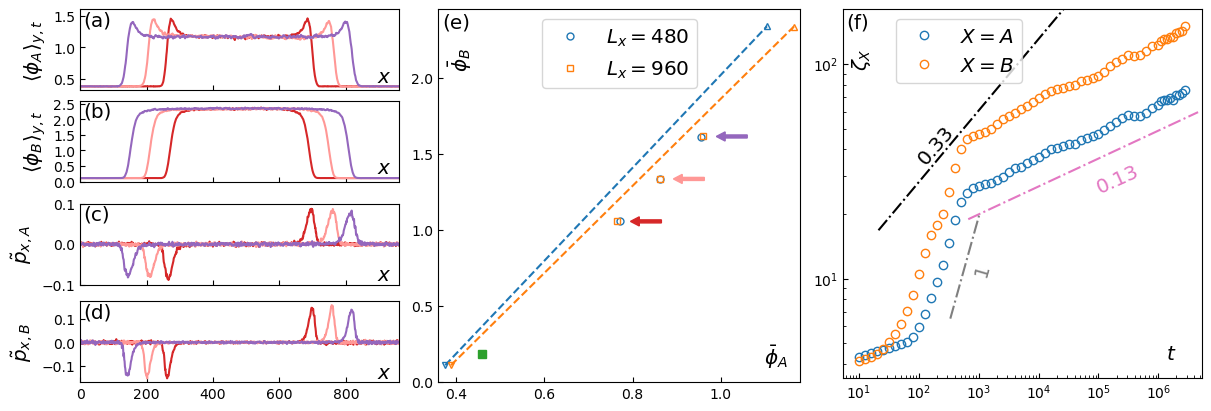

In [13]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(constrained_layout=True, figsize=(12, 4))
subfigs = fig.subfigures(1, 3, wspace=0.01, hspace=0.01, width_ratios=[1, 1, 1])

ax1, ax2, ax3, ax4 = subfigs[0].subplots(4, 1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0))
# ax3, ax4 = subfigs[1].subplots(2, 1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0))
ax5 = subfigs[1].subplots(1, 1)
ax6 = subfigs[2].subplots(1, 1)


files = ["data/lever_rule/Lx960_p7.6525_10.5675.npz",
         "data/lever_rule/Lx960_p8.625_13.36.npz",
         "data/lever_rule/Lx960_p9.597_16.152.npz"
        ]

c_list = plt.cm.get_cmap('tab20').colors[6:]
for i, fin in enumerate(files):
    with np.load(fin, "rb") as data:
        x = data["x"]
        rhoA = data["rhoA"]
        rhoB = data["rhoB"]
        mA = data["mxA"] / data["rhoA"]
        mB = data["mxB"] / data["rhoB"]
        ax1.plot(x, rhoA/10, c=c_list[i])
        ax2.plot(x, rhoB/10, c=c_list[i])
        ax3.plot(x, mA, c=c_list[i])
        ax4.plot(x, mB, c=c_list[i])
ax4.set_xlim(0, 960)

pA0 = [7.71/10, 8.625/10, 9.53875/10]
pB0 = [10.5725/10, 13.36/10, 16.1475/10]

pA1 = [7.6525/10, 8.625/10, 9.597/10]
pB1 = [10.5675/10, 13.36/10, 16.152/10]

# pA0 = [7.71/10, 9.53875/10]
# pB0 = [10.5725/10, 16.1475/10]

# pA1 = [7.6525/10, 9.597/10]
# pB1 = [10.5675/10, 16.152/10]
# for i in range(3):
#     ax5.plot(pA0[i], pB0[i], "s", c=c_list[i], fillstyle="none")
#     ax5.plot(pA1[i], pB1[i], "o", c=c_list[i], fillstyle="none")

# line1, = ax5.plot(8.625/10, 13.36/10, "ks", ms=4, zorder=2.5)
# # line2, = ax5.plot(pA1[1], pB1[1], "s", ms=4)

line1, = ax5.plot(pA0, pB0, "o", fillstyle="none", ms=5, label=r"$L_x=480$")
line2, = ax5.plot(pA1, pB1, "s", fillstyle="none", ms=5, label=r"$L_x=960$")

# x = np.linspace(0.5, 1.1, 100)
# y0 = pB0[0] + (pB0[1] - pB0[0]) / (pA0[1]-pA0[0]) * (x - pA0[0])
# y1 = pB1[0] + (pB1[1] - pB1[0]) / (pA1[1]-pA1[0]) * (x - pA1[0])
# ax5.plot(x, y0, ":", c=line1.get_c())
# ax5.plot(x, y1, ":", c=line2.get_c())

ax5.plot(3.7562/10, 1.111/10, "v", fillstyle="none", c=line1.get_c(), ms=5)
ax5.plot(11.0441/10, 23.3980/10, "^", fillstyle="none", c=line1.get_c(), ms=5)
ax5.plot([3.7562/10, 11.0441/10], [1.111/10, 23.3980/10], linestyle="dashed", c=line1.get_c())

ax5.plot(3.8868/10, 1.11095/10, "v", fillstyle="none", c=line2.get_c(), ms=4)
ax5.plot(11.6549/10, 23.3816/10, "^", fillstyle="none", c=line2.get_c(), ms=4)
ax5.plot([3.8868/10, 11.6549/10], [1.11095/10, 23.3816/10], linestyle="--", c=line2.get_c())

x0, y0 = 3.8868/10, 1.11095/10
x1, y1 = 11.6549/10, 23.3816/10
k = (y1-y0) / (x1 - x0)
x2 = 0.46
y2 = pB1[0] + k * (x2 - pA1[0])
ax5.plot(x2, y2, "s")
print(x2, y2)

ax5.legend(fontsize="x-large", loc="upper center")

ax5.arrow(7.6525/10+0.1, 10.5675/10, -0.05, 0, width=0.02, head_length=0.02, color=c_list[0])
ax5.arrow(8.625/10+0.1, 13.36/10, -0.05, 0, width=0.02, head_length=0.02, color=c_list[1])
ax5.arrow(9.597/10+0.1, 16.152/10, -0.05, 0, width=0.02, head_length=0.02, color=c_list[2])

# ax5.plot(5.5/10, 3.85/10, "*")


fs = "x-large"
ax1.set_ylabel(r"$\langle\phi_A\rangle_{y, t}$", fontsize=fs)
ax2.set_ylabel(r"$\langle\phi_B\rangle_{y, t}$", fontsize=fs)
ax3.set_ylabel(r"$\tilde{p}_{x, A}$", fontsize=fs)
ax4.set_ylabel(r"$\tilde{p}_{x, B}$", fontsize=fs)

ax1.set_ylim(ymax=1.6)
ax5.set_xlim(0.36, 1.18)
ax3.set_ylim(-0.1, 0.1)
ax2.set_ylim(0, 2.6)
ax2.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])


Sq_folder = "/home/yduan/code/Quorum_sensing/data/Sqt_rho"
fins = [
        # f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p3_6_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5.5_3.85_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        # f"{Sq_folder}/L640_640_Dr0.100_k0.70_p20_20_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        # f"{Sq_folder}/L80_80_Dr6.000_6.000_k0.70_p80_80_r80_80_80_e-0.200_-2.200_J-3.125_0.320_h0.100_1000.npz"
        ]
label_list = ["SPS", "TBC-gas", "TBC"]
dt_list = [1/3, 1/3, 1/3, 1/3]
species = ["B", "A", "B", "A"]
c_list = ["tab:blue", "tab:pink", "tab:green", "tab:orange"]
for j, fin in enumerate(fins):
    with np.load(fin, "r") as data:
        t, q, rho_Sqt, rho_var = data["t"], data["q"], data["rho_Sqt"], data["rho_var"]

    mask = t <= 3e6
    t = t[mask]
    rho_Sqt = rho_Sqt[:, mask]
    q1_A, q1_B = np.zeros((2, t.size))
    for i in range(t.size):
        q1_A[i] = get_q1(q, rho_Sqt[0][i])
        q1_B[i] = get_q1(q, rho_Sqt[1][i])
    
    RA = 2 * np.pi/q1_A
    RB = 2 * np.pi/q1_B
    
    ax6.plot(t, RA, "o", fillstyle="none", label=r"$X=A$")
    ax6.plot(t, RB, "o", fillstyle="none", label=r"$X=B$")


ax6.set_xscale("log")
ax6.set_yscale("log")

# ax6.set_xlabel(r"$t$", fontsize="x-large")
# ax6.set_ylabel(r"$\zeta_X$", fontsize="x-large")
ax6.legend(fontsize="x-large", loc=(0.15, 0.8))

add_line(ax6, 0.1, 0.4, 0.95, 1/3, label="0.33", xl=0.2, yl=0.58, c="k")
# add_line(ax5, 0.3, 0.4, 0.95, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax6, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax6, 0.3, 0.16, 0.38, 1, label="1", xl=0.36, yl=0.28, c="tab:grey")

ax1.text(0.93, 0.1, r"$x$", fontsize="x-large", transform=ax1.transAxes)
ax2.text(0.93, 0.1, r"$x$", fontsize="x-large", transform=ax2.transAxes)
ax3.text(0.93, 0.05, r"$x$", fontsize="x-large", transform=ax3.transAxes)
ax4.text(0.93, 0.05, r"$x$", fontsize="x-large", transform=ax4.transAxes)
ax5.text(0.9, 0.05, r"$\bar{\phi}_A$", fontsize="x-large", transform=ax5.transAxes)
ax5.text(0.02, 0.85, r"$\bar{\phi}_B$", fontsize="x-large", transform=ax5.transAxes, rotation=90)
ax6.text(0.9, 0.05, r"$t$", fontsize="x-large", transform=ax6.transAxes)
ax6.text(0.02, 0.85, r"$\zeta_X$", fontsize="x-large", transform=ax6.transAxes, rotation=90)

ax1.text(0.01, 0.8, "(a)", fontsize="x-large", transform=ax1.transAxes)
ax2.text(0.01, 0.8, "(b)", fontsize="x-large", transform=ax2.transAxes)
ax3.text(0.01, 0.8, "(c)", fontsize="x-large", transform=ax3.transAxes)
ax4.text(0.01, 0.8, "(d)", fontsize="x-large", transform=ax4.transAxes)
ax5.text(0.01, 0.95, "(e)", fontsize="x-large", transform=ax5.transAxes)
ax6.text(0.01, 0.95, "(f)", fontsize="x-large", transform=ax6.transAxes)

# ax4.set_xticks([0, 160, 320, 480, 640, 800, 960])
# ax2.set_ylim(ymin=0.25, ymax=1.45)
# ax3.set_ylim(ymin=0, ymax=2.8)


# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)
# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)

plt.show()
# plt.savefig("fig/S2_new.pdf")
plt.close()





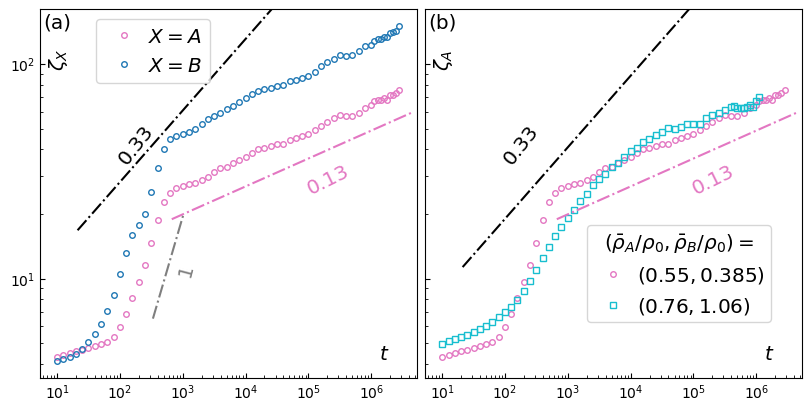

In [14]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8, 4), constrained_layout=True)


Sq_folder = "/home/yduan/code/Quorum_sensing/data/Sqt_rho"
fins = [
        # f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p3_6_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5.5_3.85_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p7.5_10_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        # f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5_8.7_r5_5_5_e-2.000_J0.500_-0.500_h0.333_1000.npz"
        # f"{Sq_folder}/L80_80_Dr6.000_6.000_k0.70_p80_80_r80_80_80_e-0.200_-2.200_J-3.125_0.320_h0.100_1000.npz"
        ]
label_list = ["SPS", "TBC-gas", "TBC"]
dt_list = [1/3, 1/3, 1/3, 1/3]
species = ["B", "A", "B", "A"]
c_list = ["tab:blue", "tab:pink", "tab:green", "tab:orange"]

ms = 4
for j, fin in enumerate(fins):
    with np.load(fin, "r") as data:
        t, q, rho_Sqt, rho_var = data["t"], data["q"], data["rho_Sqt"], data["rho_var"]

    if j == 0:
        mask = t <= 3e6
    else:
        mask = t <= 1.2e6
    t = t[mask]
    rho_Sqt = rho_Sqt[:, mask]
    q1_A, q1_B = np.zeros((2, t.size))
    for i in range(t.size):
        q1_A[i] = get_q1(q, rho_Sqt[0][i])
        q1_B[i] = get_q1(q, rho_Sqt[1][i])
    
    RA = 2 * np.pi/q1_A
    RB = 2 * np.pi/q1_B
    
    if j == 0:
        ax1.plot(t, RA, "o", fillstyle="none", label=r"$X=A$", ms=ms, c="tab:pink")
        ax1.plot(t, RB, "o", fillstyle="none", label=r"$X=B$", ms=ms)
        ax2.plot(t, RA, "o", fillstyle="none", label=r"$(0.55, 0.385)$", c="tab:pink", ms=ms)
    
    if j == 1:
        ax2.plot(t, RA, "s", fillstyle="none", label=r"$(0.76, 1.06)$", c="tab:cyan", ms=ms)

ax1.set_xscale("log")
ax1.set_yscale("log")

# ax6.set_xlabel(r"$t$", fontsize="x-large")
# ax6.set_ylabel(r"$\zeta_X$", fontsize="x-large")
ax1.legend(fontsize="x-large", loc=(0.15, 0.8), handletextpad=0.2)
ax2.legend(title=r"$(\bar{\rho}_A/\rho_0, \bar{\rho}_B/\rho_0)=$", fontsize="x-large", title_fontsize="x-large", loc=(0.43, 0.15), frameon=True, borderpad=0.3, handletextpad=0.2)
add_line(ax1, 0.1, 0.4, 0.95, 1/3, label="0.33", xl=0.2, yl=0.58, c="k")
# add_line(ax5, 0.3, 0.4, 0.95, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax1, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax1, 0.3, 0.16, 0.38, 1, label="1", xl=0.36, yl=0.28, c="tab:grey")
add_line(ax2, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax2, 0.1, 0.3, 0.95, 1/3, label="0.33", xl=0.2, yl=0.58, c="k")

ax1.text(0.9, 0.05, r"$t$", fontsize="x-large", transform=ax1.transAxes)
ax1.text(0.02, 0.85, r"$\zeta_X$", fontsize="x-large", transform=ax1.transAxes, rotation=90)
ax1.text(0.01, 0.95, "(a)", fontsize="x-large", transform=ax1.transAxes)

ax2.text(0.9, 0.05, r"$t$", fontsize="x-large", transform=ax2.transAxes)
ax2.text(0.02, 0.85, r"$\zeta_A$", fontsize="x-large", transform=ax2.transAxes, rotation=90)
ax2.text(0.01, 0.95, "(b)", fontsize="x-large", transform=ax2.transAxes)

# ax4.set_xticks([0, 160, 320, 480, 640, 800, 960])
# ax2.set_ylim(ymin=0.25, ymax=1.45)
# ax3.set_ylim(ymin=0, ymax=2.8)


# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)
# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)

plt.show()
# plt.savefig("fig/S1_v3.pdf")
plt.close()





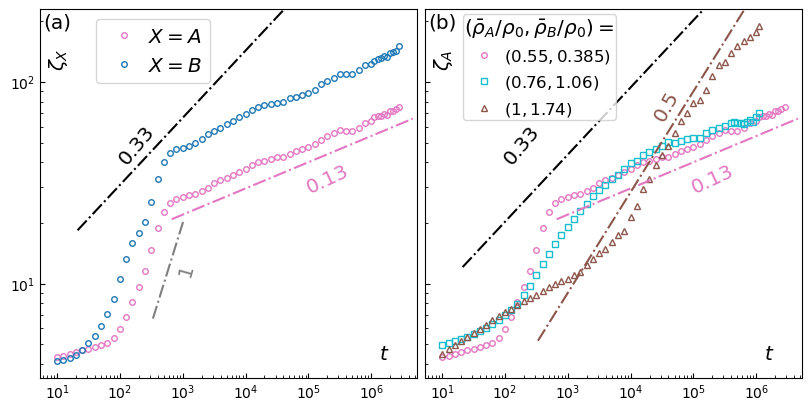

In [15]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8, 4), constrained_layout=True)


Sq_folder = "/home/yduan/code/Quorum_sensing/data/Sqt_rho"
fins = [
        # f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p3_6_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5.5_3.85_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p7.5_10_r10_10_10_e-2.000_J0.500_-0.500_h0.333_1000.npz",
        f"{Sq_folder}/L1280_1280_Dr0.100_k0.70_p5_8.7_r5_5_5_e-2.000_J0.500_-0.500_h0.333_1000.npz"
        # f"{Sq_folder}/L80_80_Dr6.000_6.000_k0.70_p80_80_r80_80_80_e-0.200_-2.200_J-3.125_0.320_h0.100_1000.npz"
        ]
label_list = ["SPS", "TBC-gas", "TBC"]
dt_list = [1/3, 1/3, 1/3, 1/3]
species = ["B", "A", "B", "A"]
c_list = ["tab:blue", "tab:pink", "tab:green", "tab:orange"]

ms = 4
for j, fin in enumerate(fins):
    with np.load(fin, "r") as data:
        t, q, rho_Sqt, rho_var = data["t"], data["q"], data["rho_Sqt"], data["rho_var"]

    if j == 0:
        mask = t <= 3e6
    else:
        mask = t <= 1.2e6
    t = t[mask]
    rho_Sqt = rho_Sqt[:, mask]
    q1_A, q1_B = np.zeros((2, t.size))
    for i in range(t.size):
        q1_A[i] = get_q1(q, rho_Sqt[0][i])
        q1_B[i] = get_q1(q, rho_Sqt[1][i])
    
    RA = 2 * np.pi/q1_A
    RB = 2 * np.pi/q1_B
    
    if j == 0:
        ax1.plot(t, RA, "o", fillstyle="none", label=r"$X=A$", ms=ms, c="tab:pink")
        ax1.plot(t, RB, "o", fillstyle="none", label=r"$X=B$", ms=ms)
        ax2.plot(t, RA, "o", fillstyle="none", label=r"$(0.55, 0.385)$", c="tab:pink", ms=ms)
    
    if j == 1:
        ax2.plot(t, RA, "s", fillstyle="none", label=r"$(0.76, 1.06)$", c="tab:cyan", ms=ms)
    if j == 2:
        ax2.plot(t, RB, "^", fillstyle="none", label=r"$(1, 1.74)$", c="tab:brown", ms=ms)

ax1.set_xscale("log")
ax1.set_yscale("log")

# ax6.set_xlabel(r"$t$", fontsize="x-large")
# ax6.set_ylabel(r"$\zeta_X$", fontsize="x-large")
ax1.legend(fontsize="x-large", loc=(0.15, 0.8), handletextpad=0.2)
ax2.legend(title=r"$(\bar{\rho}_A/\rho_0, \bar{\rho}_B/\rho_0)=$", fontsize="large", title_fontsize="x-large", loc=(0.1, 0.7), frameon=True, borderpad=0.1, handletextpad=0.2)
add_line(ax1, 0.1, 0.4, 0.95, 1/3, label="0.33", xl=0.2, yl=0.58, c="k")
# add_line(ax5, 0.3, 0.4, 0.95, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax1, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax1, 0.3, 0.16, 0.38, 1, label="1", xl=0.36, yl=0.28, c="tab:grey")
add_line(ax2, 0.35, 0.43, 0.99, 0.13, label="0.13", xl=0.7, yl=0.5, c="tab:pink")
add_line(ax2, 0.1, 0.3, 0.95, 1/3, label="0.33", xl=0.2, yl=0.58, c="k")
add_line(ax2, 0.3, 0.1, 0.95, 0.5, label="0.5", xl=0.6, yl=0.7, c="tab:brown")


ax1.text(0.9, 0.05, r"$t$", fontsize="x-large", transform=ax1.transAxes)
ax1.text(0.02, 0.85, r"$\zeta_X$", fontsize="x-large", transform=ax1.transAxes, rotation=90)
ax1.text(0.01, 0.95, "(a)", fontsize="x-large", transform=ax1.transAxes)

ax2.text(0.9, 0.05, r"$t$", fontsize="x-large", transform=ax2.transAxes)
ax2.text(0.02, 0.85, r"$\zeta_A$", fontsize="x-large", transform=ax2.transAxes, rotation=90)
ax2.text(0.01, 0.95, "(b)", fontsize="x-large", transform=ax2.transAxes)

# ax4.set_xticks([0, 160, 320, 480, 640, 800, 960])
# ax2.set_ylim(ymin=0.25, ymax=1.45)
# ax3.set_ylim(ymin=0, ymax=2.8)


# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)
# ax1.text(0.01, 0.8, r"$\langle\phi_A(\mathbf{r})\rangle_{y, t}$", transform=ax1.transAxes)

plt.show()
# plt.savefig("fig/S1_v3.pdf")
plt.close()



